In [81]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [82]:
# PJE font setting
plt.rcParams['font.family'] = 'Malgun Gothic' 

# CSV 파일 읽기
phone_df = pd.read_csv('./data/phone_information.csv', low_memory=False)

In [83]:
# 인코딩

# 범주형 변수 전처리
le = LabelEncoder()
categorical_features = ['service_purchase_21', 'money_transfer_21']

# 범주형 변수 인코딩
for feature in categorical_features:
    phone_df[feature] = le.fit_transform(phone_df[feature].astype(str))

# # 데이터 값을 unique로 찍어본 결과 str로 들어가있는 데이터가 있어 int로 형변환 해주어야 함
# object 타입인 컬럼들 찾기
object_columns = phone_df.select_dtypes(include=['object']).columns

# object 타입 컬럼들을 숫자형으로 변환
for col in object_columns:
    phone_df.loc[:, col] = pd.to_numeric(phone_df[col], errors='coerce').astype('Int64')

# 2
for col in object_columns:
    phone_df.loc[:, col] = pd.to_numeric(phone_df[col], errors='coerce').astype('float64')


# NA값이 있는 컬럼들 확인
na_columns = phone_df.columns[phone_df.isna().any()].tolist()
# NA가 있는 행을 모두 제거
phone_df = phone_df.dropna()

In [84]:
# 컬럼 정리
feature_cols_22 = [
    'email_21', 'messenger_21', 'blog_21', 'cloud_21', 'call_check_21',
    'service_purchase_21', 'money_transfer_21', 'cradit_card_21', 'agency_purchase_21',
    'machine_purchase_21', 'phone_owner_21', 'data_21', 'dmb_21', 'agency_21',
    'voice_service_21', 'data_service_21', 'use_date_21', 'age_21', 'school_21',
    'marry_21', 'salary_21', 'job_21', 'religion_21'
]

feature_cols_23 = [
    'email_22', 'messenger_22', 'blog_22', 'cloud_22', 'call_check_22',
    'service_purchase_22', 'money_transfer_22', 'cradit_card_22', 'agency_purchase_22',
    'machine_purchase_22', 'phone_owner_22', 'data_22', 'dmb_22', 'agency_22',
    'voice_service_22', 'data_service_22', 'use_date_22', 'age_22', 'school_22',
    'marry_22', 'salary_22', 'job_22', 'religion_22'
]

In [85]:
# xxs, xxx를 제거하는 코드 
phone_df = phone_df[(phone_df['brand_21'] == 1) |
                    (phone_df['brand_22'] == 1) ]

In [86]:
# 이탈 여부 (y)
# 22년 삼성이면 0, 기타면 1 
phone_df["y_22"] = phone_df['brand_22'].apply(lambda x: 0 if x == 1 else 1)
phone_df["y_23"] = phone_df['brand_23'].apply(lambda x: 0 if x == 1 else 1)

In [87]:
# x,_,_를 제거하는 코드 
phone_df_22 = phone_df[phone_df['brand_21'] == 1]

# _x_를 제거하는 코드 
phone_df_23 = phone_df[phone_df['brand_22'] == 1]

# 1. LightGBM

### 2022년 이탈자 예측 모델

In [88]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier, early_stopping
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score

In [89]:
X_22 = phone_df_22[feature_cols_22]
y_22 = phone_df_22['y_22']

In [90]:
X_22 = X_22.astype('int64')

In [91]:
X_22['service_purchase_21'] = X_22['service_purchase_21'].astype('int64')
X_22['money_transfer_21'] = X_22['money_transfer_21'].astype('int64')
X_22['cradit_card_21'] = X_22['cradit_card_21'].astype('int64')
# 타입 변경 확인 
# print(X_22.dtypes)

In [92]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_22, y_22, test_size=0.2, stratify=y_22, random_state=42)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, random_state=0, stratify=y_train, test_size=0.1)

# 클래스 비율 계산
pos_scale = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# LightGBM 모델 정의
lgbm_22 = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,  # 학습률 낮춤
    random_state=42,
    verbose=100,
    scale_pos_weight=pos_scale,
    max_depth=6,  
    min_child_samples=20,  
    subsample=0.8,  # 데이터 샘플링 비율
    colsample_bytree=0.8  # 피처 샘플링 비율
)

# 모델 학습
eval_set = [(X_tr, y_tr), (X_val, y_val)]
lgbm_22.fit(
    X_tr, 
    y_tr,
    eval_set=eval_set,
    eval_metric='auc',
    callbacks=[early_stopping(stopping_rounds=100, verbose=True)]
)

# 성능 평가
train_score = lgbm_22.score(X_train, y_train)
test_score = lgbm_22.score(X_test, y_test)

print(f'학습 정확도: {train_score:.4f}, 테스트 정확도: {test_score:.4f}')


[LightGBM] [Info] Number of positive: 376, number of negative: 4394
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.148516
[LightGBM] [Debug] init for col-wise cost 0.000006 seconds, init for row-wise cost 0.000505 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 315
[LightGBM] [Info] Number of data points in the train set: 4770, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.078826 -> initscore=-2.458406
[LightGBM] [Info] Start training from score -2.458406
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
Training until validation scores don't improve for 100 rounds
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree

In [93]:
# 오버샘플링
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# LightGBM 모델 정의
lgbm_22_os = LGBMClassifier(
    n_estimators=500,     # 트리 개수 (부스팅 반복 횟수)
    learning_rate=0.05,   # 학습률
    random_state=42,      
    # verbose=100,          # 학습 로그 출력 간격
    scale_pos_weight=1,   # (클래스 불균형 처리) # SMOTE 후 클래스 비율 균형이 맞춰지므로 scale_pos_weight를 1로 설정
    max_depth=6,          # 트리 최대 깊이
    min_child_samples=20, # 리프노드 최소 샘플 수 
    subsample=0.8,        # 훈련 데이터 샘플링 비율
    colsample_bytree=0.8  # 피처 샘플링 비율
)

# 모델 학습
lgbm_22_os.fit(X_train_resampled, y_train_resampled)

# 성능 평가
train_score = lgbm_22_os.score(X_train_resampled, y_train_resampled)
test_score = lgbm_22_os.score(X_test, y_test)

print(f'Oversampled LightGBM 22년 이탈자 \n 학습 정확도: {train_score:.4f}, 테스트 정확도: {test_score:.4f}')


[LightGBM] [Info] Number of positive: 4882, number of negative: 4882
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.857256
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.202516
[LightGBM] [Debug] init for col-wise cost 0.000526 seconds, init for row-wise cost 0.000602 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 349
[LightGBM] [Info] Number of data points in the train set: 9764, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[Lig

테스트 정확도: 0.88
테스트 AUC : 0.6670023419203748
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1220
           1       0.21      0.18      0.19       105

    accuracy                           0.88      1325
   macro avg       0.57      0.56      0.56      1325
weighted avg       0.87      0.88      0.88      1325



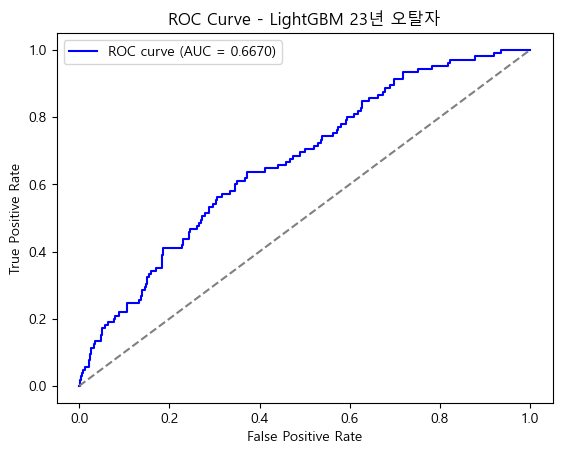

In [94]:
from sklearn.metrics import classification_report 
from sklearn.metrics import roc_curve, roc_auc_score
# 최종 평가
# 정확도
print(f'테스트 정확도: {lgbm_22_os.score(X_test, y_test)}')

# AUC 
y_pred_proba_test = lgbm_22_os.predict_proba(X_test)[:, 1]
print(f'테스트 AUC : {roc_auc_score(y_test, y_pred_proba_test)}')

# 종합 지표
print(f'{classification_report(y_test, lgbm_22_os.predict(X_test))}')

# ROC 곡선 시각화
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc_score(y_test, y_pred_proba_test):.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM 23년 오탈자')
plt.legend()
plt.show()

In [95]:
# 특성 중요도 확인
# lgbm_22.get_feature_importance(prettified=True)

# 특성 중요도 출력
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lgbm_22.feature_importances_
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

                Feature  Importance
8    agency_purchase_21           9
5   service_purchase_21           4
22          religion_21           3
13            agency_21           3
19             marry_21           2
9   machine_purchase_21           2
11              data_21           2
10       phone_owner_21           1
15      data_service_21           1
17               age_21           1
18            school_21           1
20            salary_21           1
7        cradit_card_21           0
6     money_transfer_21           0
4         call_check_21           0
1          messenger_21           0
12               dmb_21           0
3              cloud_21           0
14     voice_service_21           0
16          use_date_21           0
2               blog_21           0
21               job_21           0
0              email_21           0


### 2023년 이탈자 예측 모델

In [96]:
X_23 = phone_df_23[feature_cols_23]
y_23 = phone_df_23['y_23']

In [97]:
X_23 = X_23.astype('int64')

In [98]:
# X_23.dtypes

In [99]:
X_23['service_purchase_22'] = X_23['service_purchase_22'].astype('int64')
X_23['money_transfer_22'] = X_23['money_transfer_22'].astype('int64')
X_23['cradit_card_22'] = X_23['cradit_card_22'].astype('int64')
# print(X_23.dtypes)

In [100]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_23, y_23, test_size=0.2, stratify=y_23, random_state=42)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, random_state=0, stratify=y_train, test_size=0.1)

# 클래스 비율 계산
pos_scale = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# LightGBM 모델 정의 
lgbm_23 = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,  # 학습률 낮춤
    random_state=42,
    verbose=100,
    scale_pos_weight=pos_scale,
    max_depth=6,  # 트리 깊이 제한
    min_child_samples=20,  # 리프 노드의 최소 샘플 수
    subsample=0.8,  # 데이터 샘플링 비율
    colsample_bytree=0.8  # 피처 샘플링 비율
)

# 모델 학습
eval_set = [(X_tr, y_tr), (X_val, y_val)]
lgbm_23.fit(
    X_tr, 
    y_tr,
    eval_set=eval_set,
    eval_metric='auc',
    callbacks=[early_stopping(stopping_rounds=100, verbose=True)]
)

# 성능 평가
train_score = lgbm_23.score(X_train, y_train)
test_score = lgbm_23.score(X_test, y_test)

print(f'학습 정확도: {train_score:.4f}, 테스트 정확도: {test_score:.4f}')


[LightGBM] [Info] Number of positive: 319, number of negative: 4577
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.846558
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.206328
[LightGBM] [Debug] init for col-wise cost 0.000401 seconds, init for row-wise cost 0.000599 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000618 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 321
[LightGBM] [Info] Number of data points in the train set: 4896, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.065155 -> initscore=-2.663608
[LightGBM] [Info] Start training from score -2.663608
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
Training until validation scores don't improve for 100 rounds
[LightGBM] [Debug]

In [101]:
# 오버샘플링
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# LightGBM 모델 정의
lgbm_23_os = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,  # 학습률 낮춤
    random_state=42,
    verbose=100,
    scale_pos_weight=1,  # SMOTE 후 클래스 비율 균형이 맞춰지므로 scale_pos_weight를 1로 설정
    max_depth=6,  # 트리 깊이 제한
    min_child_samples=20,  # 리프 노드의 최소 샘플 수
    subsample=0.8,  # 데이터 샘플링 비율
    colsample_bytree=0.8  # 피처 샘플링 비율
)

# 모델 학습
lgbm_23_os.fit(X_train_resampled, y_train_resampled)

# 성능 평가
train_score = lgbm_23_os.score(X_train_resampled, y_train_resampled)
test_score = lgbm_23_os.score(X_test, y_test)

print(f'Oversampled LightGBM 23년 이탈자 \n 학습 정확도: {train_score:.4f}, 테스트 정확도: {test_score:.4f}')


[LightGBM] [Info] Number of positive: 5086, number of negative: 5086
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.874828
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.203093
[LightGBM] [Debug] init for col-wise cost 0.000761 seconds, init for row-wise cost 0.001290 seconds
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 346
[LightGBM] [Info] Number of data points in the train set: 10172, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 6
[Li

테스트 정확도: 0.8919911829537105
테스트 AUC : 0.7236217239163037
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1273
           1       0.20      0.22      0.21        88

    accuracy                           0.89      1361
   macro avg       0.57      0.58      0.57      1361
weighted avg       0.90      0.89      0.89      1361



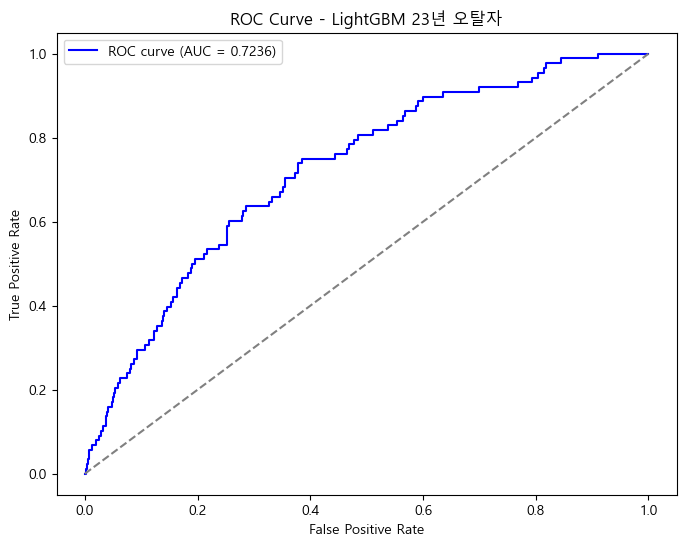

In [102]:
from sklearn.metrics import classification_report 
from sklearn.metrics import roc_curve, roc_auc_score
# 최종 평가
# 정확도
print(f'테스트 정확도: {lgbm_23_os.score(X_test, y_test)}')

# AUC 
y_pred_proba_test = lgbm_23_os.predict_proba(X_test)[:, 1]
print(f'테스트 AUC : {roc_auc_score(y_test, y_pred_proba_test)}')

# 종합 지표
print(f'{classification_report(y_test, lgbm_23_os.predict(X_test))}')

# ROC 곡선 시각화
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc_score(y_test, y_pred_proba_test):.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM 23년 오탈자')
plt.legend()
plt.show()

---

# 2. CatBoost

----

### 2022년 이탈자 예측 모델

In [103]:
from catboost import Pool
from catboost import CatBoostClassifier

In [104]:
X_train, X_test, y_train, y_test = train_test_split(X_22, y_22, test_size=0.2, random_state=42)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, random_state=0, test_size=0.1)

cb_22 = CatBoostClassifier(
    iterations=800,           # 학습 반복 횟수
    depth=5,                   # 기본값보다 줄임
    learning_rate=0.03,        # 기본값보다 줄여서 안정적으로 학습
    l2_leaf_reg=10,             # 기본값(3)보다 증가시켜 규제 강화
    bagging_temperature=0.5,   # 배깅 적용
    random_strength=1.8,       # 분할 노이즈 추가
    scale_pos_weight=8,       # 이탈자(1)의 비율을 고려해 설정 # 가중치 ❗❗❗❗❗
    random_seed=42
)


cb_22.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

y_pred_22 = cb_22.predict(X_test)
print(f'CatBoost 22년 이탈자 모델 정확도 : {accuracy_score(y_test, y_pred_22):.4f}')

0:	learn: 0.6892115	test: 0.6890673	best: 0.6890673 (0)	total: 4.82ms	remaining: 3.85s
1:	learn: 0.6849816	test: 0.6848299	best: 0.6848299 (1)	total: 9.4ms	remaining: 3.75s
2:	learn: 0.6808235	test: 0.6807698	best: 0.6807698 (2)	total: 13.7ms	remaining: 3.63s
3:	learn: 0.6772734	test: 0.6771175	best: 0.6771175 (3)	total: 18.4ms	remaining: 3.66s
4:	learn: 0.6733100	test: 0.6737513	best: 0.6737513 (4)	total: 22.9ms	remaining: 3.64s
5:	learn: 0.6702460	test: 0.6705959	best: 0.6705959 (5)	total: 29.7ms	remaining: 3.92s
6:	learn: 0.6667426	test: 0.6671873	best: 0.6671873 (6)	total: 35.9ms	remaining: 4.07s
7:	learn: 0.6636751	test: 0.6643583	best: 0.6643583 (7)	total: 41.8ms	remaining: 4.13s
8:	learn: 0.6607443	test: 0.6614315	best: 0.6614315 (8)	total: 47.7ms	remaining: 4.19s
9:	learn: 0.6579103	test: 0.6585896	best: 0.6585896 (9)	total: 54ms	remaining: 4.27s
10:	learn: 0.6551589	test: 0.6559956	best: 0.6559956 (10)	total: 61.1ms	remaining: 4.38s
11:	learn: 0.6530188	test: 0.6543695	best: 0

AUC: 0.7270

[Precision, Recall, F1-score, Support]
              precision    recall  f1-score   support

           0       0.95      0.85      0.90      1220
           1       0.21      0.46      0.29       105

    accuracy                           0.82      1325
   macro avg       0.58      0.65      0.59      1325
weighted avg       0.89      0.82      0.85      1325



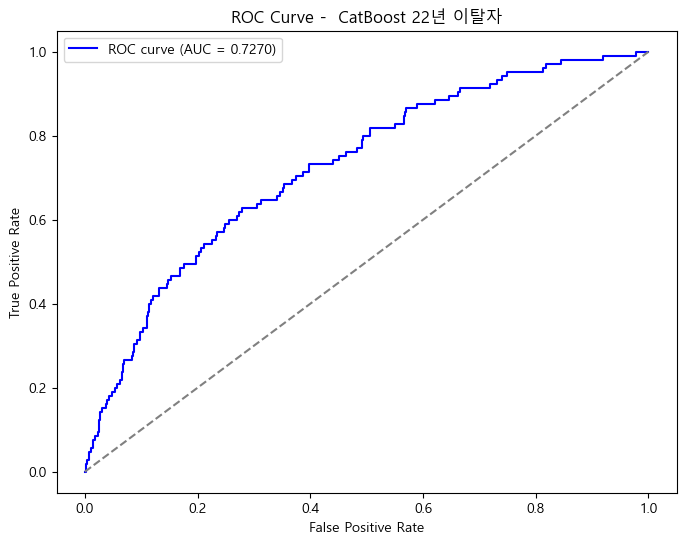

In [105]:
# 예측 확률 및 클래스 예측
y_pred_proba = cb_22.predict_proba(X_test)[:, 1]  # 클래스 1의 확률 예측
y_pred = cb_22.predict(X_test)  # 최종 클래스 예측

# AUC 계산
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.4f}")

# Precision, Recall, F1-score, Support 출력
print("\n[Precision, Recall, F1-score, Support]")
print(classification_report(y_test, y_pred))

# ROC 곡선 그래프 그리기
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # 대각선 기준선
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve -  CatBoost 22년 이탈자')
plt.legend()
plt.show()


In [106]:
# 오버샘플링 
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

cb_22_os = CatBoostClassifier(
    learning_rate=0.05,
    iterations=1000,
    depth=6,
    l2_leaf_reg=3,
    bagging_temperature=0.7,
    random_seed=42
)
cb_22_os.fit(X_res, y_res, eval_set=(X_val, y_val), early_stopping_rounds=100)

# 성능 평가
train_score = cb_22_os.score(X_res, y_res)
test_score = cb_22_os.score(X_test, y_test)

print(f'Oversampled CatBoost 22년 이탈자 \n 학습 정확도: {train_score:.4f}, 테스트 정확도: {test_score:.4f}')


0:	learn: 0.6696367	test: 0.6730301	best: 0.6730301 (0)	total: 6.46ms	remaining: 6.45s
1:	learn: 0.6479597	test: 0.6543414	best: 0.6543414 (1)	total: 12.9ms	remaining: 6.42s
2:	learn: 0.6276446	test: 0.6397079	best: 0.6397079 (2)	total: 19.6ms	remaining: 6.5s
3:	learn: 0.6109501	test: 0.6244122	best: 0.6244122 (3)	total: 26.3ms	remaining: 6.54s
4:	learn: 0.5972327	test: 0.6122247	best: 0.6122247 (4)	total: 33.3ms	remaining: 6.62s
5:	learn: 0.5807698	test: 0.6007404	best: 0.6007404 (5)	total: 39.3ms	remaining: 6.5s
6:	learn: 0.5690255	test: 0.5897999	best: 0.5897999 (6)	total: 45.6ms	remaining: 6.46s
7:	learn: 0.5586636	test: 0.5799504	best: 0.5799504 (7)	total: 51.7ms	remaining: 6.4s
8:	learn: 0.5461699	test: 0.5707739	best: 0.5707739 (8)	total: 57.1ms	remaining: 6.29s
9:	learn: 0.5371655	test: 0.5627996	best: 0.5627996 (9)	total: 63.3ms	remaining: 6.27s
10:	learn: 0.5292481	test: 0.5552896	best: 0.5552896 (10)	total: 68.9ms	remaining: 6.19s
11:	learn: 0.5225582	test: 0.5487749	best: 0

AUC: 0.6497

[Precision, Recall, F1-score, Support]
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      1220
           1       0.20      0.18      0.19       105

    accuracy                           0.88      1325
   macro avg       0.57      0.56      0.56      1325
weighted avg       0.87      0.88      0.87      1325



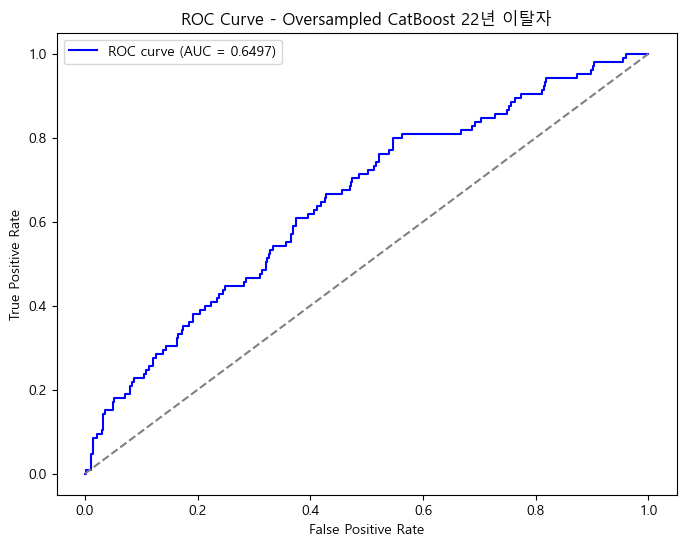

In [ ]:
# 오버 샘플링 예측 확률 및 클래스 예측
y_pred_proba = cb_22_os.predict_proba(X_test)[:, 1]  # 클래스 1의 확률 예측
y_pred = cb_22_os.predict(X_test)  # 최종 클래스 예측

# AUC 계산
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.4f}")

# Precision, Recall, F1-score, Support 출력
print("\n[Precision, Recall, F1-score, Support]")
print(classification_report(y_test, y_pred))

# ROC 곡선 그래프 그리기
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # 대각선 기준선
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Oversampled CatBoost 22년 이탈자')
plt.legend()
plt.show()


### 2023년 이탈자 예측 모델

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X_23, y_23, test_size=0.2, random_state=42)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, random_state=0, test_size=0.1)

cb_23 = CatBoostClassifier(
    iterations=500,
    depth=6, 
    learning_rate=0.1, 
    loss_function='Logloss', 
    verbose=100,
    scale_pos_weight=10,  # 이탈자(1)의 비율을 고려해 설정 # 가중치 ❗❗❗❗❗
)
cb_23.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

y_pred_23 = cb_23.predict(X_test)
print(f'CatBoost 23년 이탈자 모델 정확도 : {accuracy_score(y_test, y_pred_23):.4f}')

0:	learn: 0.6731967	test: 0.6741691	best: 0.6741691 (0)	total: 3.68ms	remaining: 1.84s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.5859915941
bestIteration = 17

Shrink model to first 18 iterations.
CatBoost 23년 이탈자 모델 정확도 : 0.8082


AUC: 0.7466

[Precision, Recall, F1-score, Support]
              precision    recall  f1-score   support

           0       0.96      0.83      0.89      1273
           1       0.17      0.52      0.26        88

    accuracy                           0.81      1361
   macro avg       0.57      0.68      0.58      1361
weighted avg       0.91      0.81      0.85      1361



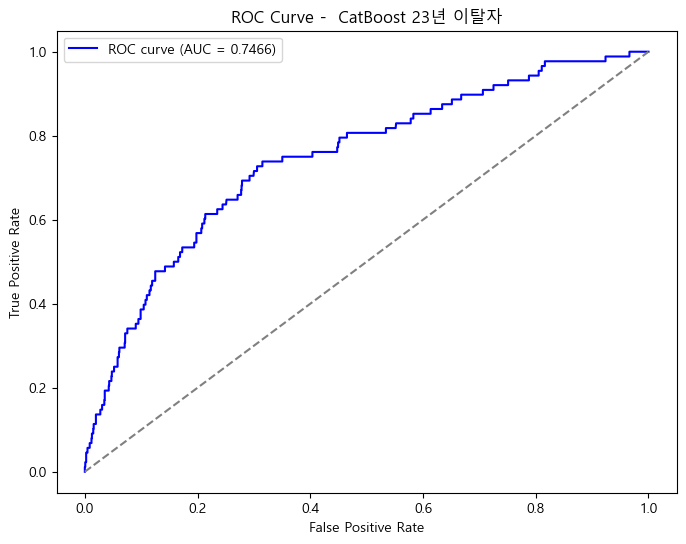

In [109]:
# 예측 확률 및 클래스 예측
y_pred_proba = cb_23.predict_proba(X_test)[:, 1]  # 클래스 1의 확률 예측
y_pred = cb_23.predict(X_test)  # 최종 클래스 예측

# AUC 계산
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.4f}")

# Precision, Recall, F1-score, Support 출력
print("\n[Precision, Recall, F1-score, Support]")
print(classification_report(y_test, y_pred))

# ROC 곡선 그래프 그리기
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # 대각선 기준선
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve -  CatBoost 23년 이탈자')
plt.legend()
plt.show()


In [110]:
# 오버샘플링 
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

cb_23_os = CatBoostClassifier(
    learning_rate=0.05,
    iterations=1000,
    depth=6,
    l2_leaf_reg=3,
    bagging_temperature=0.7,
    random_seed=42
)
cb_23_os.fit(X_res, y_res, eval_set=(X_val, y_val), early_stopping_rounds=100)

# 성능 평가
train_score = cb_23_os.score(X_res, y_res)
test_score = cb_23_os.score(X_test, y_test)

print(f'Oversampled CatBoost 23년 이탈자 \n 학습 정확도: {train_score:.4f}, 테스트 정확도: {test_score:.4f}')


0:	learn: 0.6607522	test: 0.6624281	best: 0.6624281 (0)	total: 10.6ms	remaining: 10.5s
1:	learn: 0.6347537	test: 0.6364047	best: 0.6364047 (1)	total: 20ms	remaining: 9.99s
2:	learn: 0.6066202	test: 0.6132449	best: 0.6132449 (2)	total: 29.2ms	remaining: 9.7s
3:	learn: 0.5827379	test: 0.5909836	best: 0.5909836 (3)	total: 39.4ms	remaining: 9.81s
4:	learn: 0.5634179	test: 0.5714860	best: 0.5714860 (4)	total: 48.6ms	remaining: 9.66s
5:	learn: 0.5477929	test: 0.5546700	best: 0.5546700 (5)	total: 58.4ms	remaining: 9.67s
6:	learn: 0.5336688	test: 0.5404242	best: 0.5404242 (6)	total: 68.4ms	remaining: 9.71s
7:	learn: 0.5199045	test: 0.5269669	best: 0.5269669 (7)	total: 78ms	remaining: 9.67s
8:	learn: 0.5052497	test: 0.5149861	best: 0.5149861 (8)	total: 87.8ms	remaining: 9.66s
9:	learn: 0.4939833	test: 0.5026684	best: 0.5026684 (9)	total: 97.6ms	remaining: 9.66s
10:	learn: 0.4833063	test: 0.4930872	best: 0.4930872 (10)	total: 107ms	remaining: 9.64s
11:	learn: 0.4729890	test: 0.4834518	best: 0.48

AUC: 0.7038

[Precision, Recall, F1-score, Support]
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      1273
           1       0.26      0.25      0.25        88

    accuracy                           0.91      1361
   macro avg       0.60      0.60      0.60      1361
weighted avg       0.90      0.91      0.90      1361



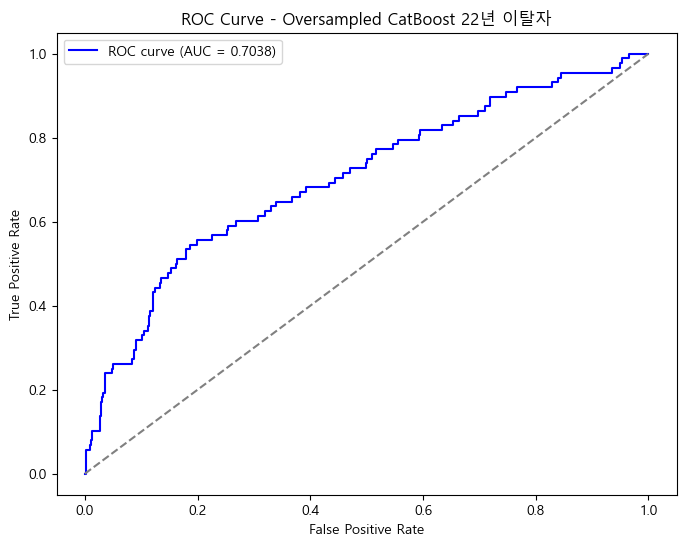

In [ ]:
# 오버 샘플링 예측 확률 및 클래스 예측
y_pred_proba = cb_23_os.predict_proba(X_test)[:, 1]  # 클래스 1의 확률 예측
y_pred = cb_23_os.predict(X_test)  # 최종 클래스 예측

# AUC 계산
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc:.4f}")

# Precision, Recall, F1-score, Support 출력
print("\n[Precision, Recall, F1-score, Support]")
print(classification_report(y_test, y_pred))

# ROC 곡선 그래프 그리기
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # 대각선 기준선
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Oversampled CatBoost 22년 이탈자')
plt.legend()
plt.show()
